# Lab 5: Deep learning based end-to-end speech recognition 

The goal of this assignment is to get familiar with applications that require speech data as input.

We would be using the torchaudio library (pip install torchaudio==0.11.0), please carefull read this tutorial https://pytorch.org/tutorials/intermediate/speech_recognition_pipeline_tutorial.html

Next, we would ask you to perform similar analysis on a speech dataset, i.e., speechdata.zip. Unzip this folder, you would see a folder named wavs, and a file called "labels.csv", containing annotated transcripts, including the files in the wavs folder (you have more labels in labels.csv). This dataset is selected from https://keithito.com/LJ-Speech-Dataset/, a famous speech-based application benchmark.

General torchaudio tutorials: https://pytorch.org/tutorials/index.html

**Submission: submit via onq.** 


## Import Libiraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install -q torchaudio==0.11.0

In [3]:
! pip install -q jiwer

In [4]:
# Import needed libraries.
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
import torch
import torchaudio
from pathlib import Path

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA
import scipy.io.wavfile as wavfile

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import wave, sys
 
import re
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
import glob
from glob import glob

%matplotlib inline

## Task 1: Basic data exploration
Select one randomly sampled wav file in the given folder, perform the following analysis:

1) Print the shape of the picked waveform

2) Print the sample rate of the waveform. 

3) Visualize the waveform using matplotlib

4) Create the spectrogram representation of the picked waveform and visualize it. 

5) Create the MFCC representation of the picked waveform and visualize it.

Reference: https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration/notebook 

In [5]:
# TODO code for task 1
waveform, sample_rate = torchaudio.load('/content/drive/MyDrive/wavs/LJ001-0012.wav')
waveform.size(), sample_rate

(torch.Size([1, 181661]), 22050)

In [6]:
ipd.Audio('/content/drive/MyDrive/wavs/LJ001-0012.wav')

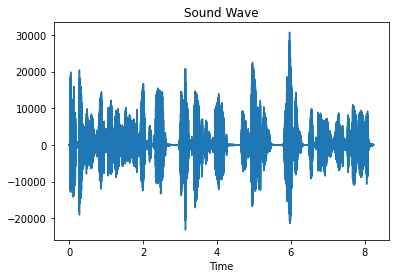

In [7]:
# shows the sound waves
def visualize(path: str):

    # reading the audio file
    raw = wave.open(path)
     
    # reads all the frames
    signal = raw.readframes(-1)
    signal = np.frombuffer(signal, dtype ="int16")
     
    # gets the frame rate
    f_rate = raw.getframerate()
    time = np.linspace(0,len(signal) / f_rate,num = len(signal))
    plt.figure(1)
     
    # title of the plot
    plt.title("Sound Wave")
     
    # label of x-axis
    plt.xlabel("Time")    
    plt.plot(time, signal)
    plt.show() 
    
if __name__ == "__main__":   
    path = sys.argv[1] 
    visualize('/content/drive/MyDrive/wavs/LJ001-0012.wav')

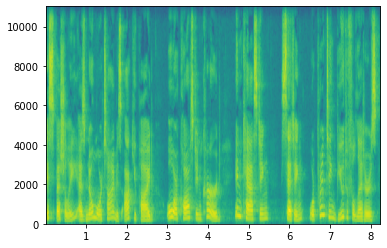

In [8]:
Fs, aud = wavfile.read('/content/drive/MyDrive/wavs/LJ001-0012.wav')
# trim the first 125 seconds
first = aud[:int(Fs*125)]
powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(first, Fs=Fs)
plt.show()

<function matplotlib.pyplot.show>

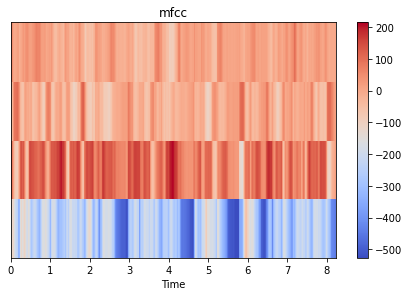

In [9]:
import librosa
audio_path='/content/drive/MyDrive/wavs/LJ001-0012.wav' #location
(xf, sr) = librosa.load(audio_path)    
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=4)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.title('mfcc')
plt.show

## Task 2: Creating a Wav2Vec2 model that can perform feature extraction and classification.


In [10]:
# TODO code for task 2
def translate(waveform):
    bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
    torch.random.manual_seed(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = bundle.get_model().to(device)

    waveform = waveform.to(device)
    
    if sample_rate != bundle.sample_rate:
      waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    
    with torch.inference_mode():
        features, _ = model.extract_features(waveform)
    
    with torch.inference_mode():
        emission, _ = model(waveform)
    
    class GreedyCTCDecoder(torch.nn.Module):
      def __init__(self, labels, blank=0):
          super().__init__()
          self.labels = labels
          self.blank = blank

      def forward(self, emission: torch.Tensor) -> str:
          """Given a sequence emission over labels, get the best path string
          Args:
            emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

          Returns:
            str: The resulting transcript
          """
          indices = torch.argmax(emission, dim=-1)  # [num_seq,]
          indices = torch.unique_consecutive(indices, dim=-1)
          indices = [i for i in indices if i != self.blank]
          return "".join([self.labels[i] for i in indices])

    decoder = GreedyCTCDecoder(labels=bundle.get_labels())
    transcript = decoder(emission[0])
    print(transcript)
    return transcript

In [11]:
translate(waveform)
ipd.Audio('/content/drive/MyDrive/wavs/LJ001-0012.wav')

ESPECIALLY|AS|NO|MORE|TIME|IS|OCCUPIED|OR|COST|INCURRED|INCASTING|SETTING|OR|PRINTING|BEAUTIFUL|LETTERS|


## Task 3: Extract acoustic features and generate predicted transcript for each waveform in the given dataset

In [12]:
# TODO code for task 3
# 100 file wavs 
# Array contains the 100 predicted transcript (hypothesis)
directory = Path('/content/drive/MyDrive/wavs')
choices = [path.name for path in directory.glob("*.wav")]
dataa=[]
for i in range(100):
    waveform, sample_rate = torchaudio.load('/content/drive/MyDrive/wavs/'+choices[i])
    dataa.append(translate(waveform))

THE|WORST|WHICH|PERHAPS|WAS|THE|ENGLISH|WAS|A|TERRIBLE|FALLING|OFF|FROM|THE|WORK|OF|THE|EARLIER|PRESSES|
IN|ENGLAND|ABOUT|THIS|TIME|AN|ATTEMPT|WAS|MADE|NOTABLY|BY|CASLON|WHO|STARTED|BUSINESS|IN|LONDON|AS|A|TYPE|FOUNDER|IN|SEVENTEEN|TWENTY|
AFTER|HIS|DEATH|IN|THE|FOURTEEN|EIGHTIES|OR|AT|LEAST|BY|FOURTEEN|NINETY|PRINTING|IN|VENICE|HAD|DECLINED|VERY|MUCH|
WHICH|WAS|GENERALLY|MORE|FORMALLY|GOTHIC|THAN|THE|PRINTING|OF|THE|GERMAN|WORKMEN|
THE|BEST|MOSTLY|FRENCH|OR|LOW|COUNTRY|WAS|NEAT|AND|CLEAR|BUT|WITHOUT|ANY|DISTINCTION|
HIS|LETTER|IS|ADMIRABLY|CLEAR|AND|REGULAR|BUT|AT|LEAST|AS|BEAUTIFUL|AS|ANY|OTHER|ROM|IN|TYPE|
AND|THESE|SOMEWHAT|WIRY|LETTERS|ARE|SUITABLE|FOR|THE|MACHINE|PROCESS|WHICH|WOULD|NOT|DO|JUSTICE|TO|LETTERS|OF|MORE|GENEROUS|DESIGN|
THE|ROMAN|LETTER|WAS|USED|SIDE|BY|SIDE|WITH|THE|GOTHIC|
MUST|BE|UNDERSTOOD|THAT|THROUGH|THE|WHOLE|OF|THE|FIFTEENTH|AND|THE|FIRST|QUARTER|OF|THE|SIXTEENTH|CENTURIES|
WERE|THE|LEADERS|IN|THIS|LUCKLESS|CHANGE|THOUGH|OUR|OWN|BASKERVILLE|WHO|WAS|AT|WORK|SO

In [13]:
df=pd.DataFrame()
df['file_name']=choices
df['transcript']=dataa
df

,file_name,transcript
0,LJ001-0075.wav,THE|WORST|WHICH|PERHAPS|WAS|THE|ENGLISH|WAS|A|...
1,LJ001-0077.wav,IN|ENGLAND|ABOUT|THIS|TIME|AN|ATTEMPT|WAS|MADE...
2,LJ001-0049.wav,AFTER|HIS|DEATH|IN|THE|FOURTEEN|EIGHTIES|OR|AT...
3,LJ001-0063.wav,WHICH|WAS|GENERALLY|MORE|FORMALLY|GOTHIC|THAN|...
4,LJ001-0074.wav,THE|BEST|MOSTLY|FRENCH|OR|LOW|COUNTRY|WAS|NEAT...
...,...,...
95,LJ001-0044.wav,JOHN|OF|SPIRES|AND|HIS|BROTHER|VINDOLYN|FOLLOW...
96,LJ001-0095.wav,THESE|AND|SIMILAR|FOUNTS|CAST|BY|THE|ABOVE|FIR...
97,LJ001-0047.wav,OF|JENSON|IT|MUST|BE|SAID|THAT|HE|CARRIED|THE|...
98,LJ001-0046.wav,THEIR|TYPE|IS|ON|THE|LINES|OF|THE|GERMAN|AND|F...


In [14]:
df['file_name'],_=df['file_name'].str.split('.wav', 1).str

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Columnar iteration over characters will be deprecated in future releases.



In [15]:
df

,file_name,transcript
0,LJ001-0075,THE|WORST|WHICH|PERHAPS|WAS|THE|ENGLISH|WAS|A|...
1,LJ001-0077,IN|ENGLAND|ABOUT|THIS|TIME|AN|ATTEMPT|WAS|MADE...
2,LJ001-0049,AFTER|HIS|DEATH|IN|THE|FOURTEEN|EIGHTIES|OR|AT...
3,LJ001-0063,WHICH|WAS|GENERALLY|MORE|FORMALLY|GOTHIC|THAN|...
4,LJ001-0074,THE|BEST|MOSTLY|FRENCH|OR|LOW|COUNTRY|WAS|NEAT...
...,...,...
95,LJ001-0044,JOHN|OF|SPIRES|AND|HIS|BROTHER|VINDOLYN|FOLLOW...
96,LJ001-0095,THESE|AND|SIMILAR|FOUNTS|CAST|BY|THE|ABOVE|FIR...
97,LJ001-0047,OF|JENSON|IT|MUST|BE|SAID|THAT|HE|CARRIED|THE|...
98,LJ001-0046,THEIR|TYPE|IS|ON|THE|LINES|OF|THE|GERMAN|AND|F...


## Task 4: evaluate the performance of the trained model on the testing dataset using Word Error Rate (WER), Match Error Rate (MER)

Hint: consider this package, https://pypi.org/project/jiwer/

In [16]:
# TODO code for task 4
da = pd.read_excel('/content/labels.xlsx', header=None,index_col=None)
data=pd.DataFrame()
data['colA']=da[0]
data['label'],data['trans']=data['colA'].str.split('|', 1).str
data['trans'],_=data['trans'].str.split('|', 1).str
data=data.drop(columns=['colA'])
data=data[:99]
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Columnar iteration over characters will be deprecated in future releases.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Columnar iteration over characters will be deprecated in future releases.



,label,trans
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...
...,...,...
94,LJ001-0096,have now come into general use and are obvious...
95,LJ001-0097,a little reduced in ugliness. The design of th...
96,LJ001-0098,"and the whole effect is a little too gray, owi..."
97,LJ001-0099,"It must be remembered, however, that most mode..."


In [17]:
df['target']=np.nan
for n in range(len(df['file_name'])):
    for i in range(len(data['label'])): 
        if df['file_name'][n]==data['label'][i]:
          df['target'][n]=data['trans'][i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
df

,file_name,transcript,target
0,LJ001-0075,THE|WORST|WHICH|PERHAPS|WAS|THE|ENGLISH|WAS|A|...,"the worst, which perhaps was the English, was ..."
1,LJ001-0077,IN|ENGLAND|ABOUT|THIS|TIME|AN|ATTEMPT|WAS|MADE...,"In England about this time, an attempt was mad..."
2,LJ001-0049,AFTER|HIS|DEATH|IN|THE|FOURTEEN|EIGHTIES|OR|AT...,"After his death in the fourteen eighties"","" or..."
3,LJ001-0063,WHICH|WAS|GENERALLY|MORE|FORMALLY|GOTHIC|THAN|...,which was generally more formally Gothic than ...
4,LJ001-0074,THE|BEST|MOSTLY|FRENCH|OR|LOW|COUNTRY|WAS|NEAT...,"the best, mostly French or Low-Country, was ne..."
...,...,...,...
95,LJ001-0044,JOHN|OF|SPIRES|AND|HIS|BROTHER|VINDOLYN|FOLLOW...,"John of Spires and his brother Vindelin, follo..."
96,LJ001-0095,THESE|AND|SIMILAR|FOUNTS|CAST|BY|THE|ABOVE|FIR...,"These and similar founts, cast by the above fi..."
97,LJ001-0047,OF|JENSON|IT|MUST|BE|SAID|THAT|HE|CARRIED|THE|...,Of Jenson it must be said that he carried the ...
98,LJ001-0046,THEIR|TYPE|IS|ON|THE|LINES|OF|THE|GERMAN|AND|F...,their type is on the lines of the German and F...


In [19]:
df['transcript'] = df['transcript'].str.translate(str.maketrans({'|':' '}))

In [20]:
# cleaned_corpus = pd.DataFrame()
# def cleaned(trans_data):
#     global cleaned_corpus
#     for row in trans_data:
#         dat_a = []
#         for word in row.split():
#             x1 = re.sub(pattern='[^a-zA-Z_]',repl=' ',string=word)
#             x2 = x1.lower()
#             dat_a.append(x2)
#         cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(dat_a)), ignore_index=True)
#     return cleaned_corpus

In [21]:
# df['transcript']=cleaned(df['transcript'])

In [22]:
df[df['target'].isna()]

,file_name,transcript,target
46,LJ001-0020,THE LOWER CASE BEING IN FACT INVENTED IN THE E...,NaN


In [23]:
df=df.dropna()

In [24]:
# df['target']=cleaned(df['target'])

In [25]:
df

,file_name,transcript,target
0,LJ001-0075,THE WORST WHICH PERHAPS WAS THE ENGLISH WAS A ...,"the worst, which perhaps was the English, was ..."
1,LJ001-0077,IN ENGLAND ABOUT THIS TIME AN ATTEMPT WAS MADE...,"In England about this time, an attempt was mad..."
2,LJ001-0049,AFTER HIS DEATH IN THE FOURTEEN EIGHTIES OR AT...,"After his death in the fourteen eighties"","" or..."
3,LJ001-0063,WHICH WAS GENERALLY MORE FORMALLY GOTHIC THAN ...,which was generally more formally Gothic than ...
4,LJ001-0074,THE BEST MOSTLY FRENCH OR LOW COUNTRY WAS NEAT...,"the best, mostly French or Low-Country, was ne..."
...,...,...,...
95,LJ001-0044,JOHN OF SPIRES AND HIS BROTHER VINDOLYN FOLLOW...,"John of Spires and his brother Vindelin, follo..."
96,LJ001-0095,THESE AND SIMILAR FOUNTS CAST BY THE ABOVE FIR...,"These and similar founts, cast by the above fi..."
97,LJ001-0047,OF JENSON IT MUST BE SAID THAT HE CARRIED THE ...,Of Jenson it must be said that he carried the ...
98,LJ001-0046,THEIR TYPE IS ON THE LINES OF THE GERMAN AND F...,their type is on the lines of the German and F...


In [26]:
df=df.reset_index()
df=df.drop(columns=['index'])
df

,file_name,transcript,target
0,LJ001-0075,THE WORST WHICH PERHAPS WAS THE ENGLISH WAS A ...,"the worst, which perhaps was the English, was ..."
1,LJ001-0077,IN ENGLAND ABOUT THIS TIME AN ATTEMPT WAS MADE...,"In England about this time, an attempt was mad..."
2,LJ001-0049,AFTER HIS DEATH IN THE FOURTEEN EIGHTIES OR AT...,"After his death in the fourteen eighties"","" or..."
3,LJ001-0063,WHICH WAS GENERALLY MORE FORMALLY GOTHIC THAN ...,which was generally more formally Gothic than ...
4,LJ001-0074,THE BEST MOSTLY FRENCH OR LOW COUNTRY WAS NEAT...,"the best, mostly French or Low-Country, was ne..."
...,...,...,...
94,LJ001-0044,JOHN OF SPIRES AND HIS BROTHER VINDOLYN FOLLOW...,"John of Spires and his brother Vindelin, follo..."
95,LJ001-0095,THESE AND SIMILAR FOUNTS CAST BY THE ABOVE FIR...,"These and similar founts, cast by the above fi..."
96,LJ001-0047,OF JENSON IT MUST BE SAID THAT HE CARRIED THE ...,Of Jenson it must be said that he carried the ...
97,LJ001-0046,THEIR TYPE IS ON THE LINES OF THE GERMAN AND F...,their type is on the lines of the German and F...


In [27]:
import jiwer
WeR=[]
transformation = jiwer.Compose([jiwer.ToLowerCase(), jiwer.RemoveWhiteSpace(replace_by_space=True),
                                jiwer.RemoveMultipleSpaces(), jiwer.ReduceToListOfListOfWords(word_delimiter=" ")]) 

for i in range (len(df['target'])):
  
    WER=jiwer.wer(df['target'][i],df['transcript'][i], 
                  truth_transform=transformation, 
                  hypothesis_transform=transformation)
    WeR.append(WER)

In [28]:
df['wer']=WeR
df

,file_name,transcript,target,wer
0,LJ001-0075,THE WORST WHICH PERHAPS WAS THE ENGLISH WAS A ...,"the worst, which perhaps was the English, was ...",0.222222
1,LJ001-0077,IN ENGLAND ABOUT THIS TIME AN ATTEMPT WAS MADE...,"In England about this time, an attempt was mad...",0.318182
2,LJ001-0049,AFTER HIS DEATH IN THE FOURTEEN EIGHTIES OR AT...,"After his death in the fourteen eighties"","" or...",0.157895
3,LJ001-0063,WHICH WAS GENERALLY MORE FORMALLY GOTHIC THAN ...,which was generally more formally Gothic than ...,0.076923
4,LJ001-0074,THE BEST MOSTLY FRENCH OR LOW COUNTRY WAS NEAT...,"the best, mostly French or Low-Country, was ne...",0.285714
...,...,...,...,...
94,LJ001-0044,JOHN OF SPIRES AND HIS BROTHER VINDOLYN FOLLOW...,"John of Spires and his brother Vindelin, follo...",0.176471
95,LJ001-0095,THESE AND SIMILAR FOUNTS CAST BY THE ABOVE FIR...,"These and similar founts, cast by the above fi...",0.181818
96,LJ001-0047,OF JENSON IT MUST BE SAID THAT HE CARRIED THE ...,Of Jenson it must be said that he carried the ...,0.050000
97,LJ001-0046,THEIR TYPE IS ON THE LINES OF THE GERMAN AND F...,their type is on the lines of the German and F...,0.058824


In [29]:
MeR=[]
for i in range (len(df['target'])):  
    mer = jiwer.mer(df['target'][i],df['transcript'][i], 
                  truth_transform=transformation, 
                  hypothesis_transform=transformation)
    MeR.append(mer)

In [30]:
df['mer']=MeR
df

,file_name,transcript,target,wer,mer
0,LJ001-0075,THE WORST WHICH PERHAPS WAS THE ENGLISH WAS A ...,"the worst, which perhaps was the English, was ...",0.222222,0.210526
1,LJ001-0077,IN ENGLAND ABOUT THIS TIME AN ATTEMPT WAS MADE...,"In England about this time, an attempt was mad...",0.318182,0.291667
2,LJ001-0049,AFTER HIS DEATH IN THE FOURTEEN EIGHTIES OR AT...,"After his death in the fourteen eighties"","" or...",0.157895,0.150000
3,LJ001-0063,WHICH WAS GENERALLY MORE FORMALLY GOTHIC THAN ...,which was generally more formally Gothic than ...,0.076923,0.076923
4,LJ001-0074,THE BEST MOSTLY FRENCH OR LOW COUNTRY WAS NEAT...,"the best, mostly French or Low-Country, was ne...",0.285714,0.266667
...,...,...,...,...,...
94,LJ001-0044,JOHN OF SPIRES AND HIS BROTHER VINDOLYN FOLLOW...,"John of Spires and his brother Vindelin, follo...",0.176471,0.176471
95,LJ001-0095,THESE AND SIMILAR FOUNTS CAST BY THE ABOVE FIR...,"These and similar founts, cast by the above fi...",0.181818,0.181818
96,LJ001-0047,OF JENSON IT MUST BE SAID THAT HE CARRIED THE ...,Of Jenson it must be said that he carried the ...,0.050000,0.050000
97,LJ001-0046,THEIR TYPE IS ON THE LINES OF THE GERMAN AND F...,their type is on the lines of the German and F...,0.058824,0.058824


## Task 5: check files with the worst performance and perform a simple error analysis, e.g., what are the files having worser performance, and what are the potential reasons, do they share any common patterns?


In [31]:
# TODO code for task 5
df.sort_values('wer',ascending=False)

,file_name,transcript,target,wer,mer
15,LJ001-0073,WENT ON APACE AND BY THE END OF THE SIXTEENTH ...,went on apace,5.000000,0.833333
61,LJ001-0027,ESPECIALLY AS REGARDS THE LOWER CASE LETTERS A...,especially as regards the lower-case letters,3.166667,0.791667
86,LJ001-0045,FOURTEEN SIXTY NINE FOURTEEN SEVENTY,"1469, 1470",2.500000,1.000000
29,LJ001-0034,THEY PRINTED VERY FEW BOOKS IN THIS TYPE THREE...,"They printed very few books in this type, thre...",1.600000,0.640000
63,LJ001-0040,AND IS VERY SIMPLE AND LEGIBLE AND UNAFFECTEDL...,"and is very simple and legible, and unaffected...",0.818182,0.473684
...,...,...,...,...,...
8,LJ001-0060,MUST BE UNDERSTOOD THAT THROUGH THE WHOLE OF T...,It must be understood that through the whole o...,0.052632,0.052632
96,LJ001-0047,OF JENSON IT MUST BE SAID THAT HE CARRIED THE ...,Of Jenson it must be said that he carried the ...,0.050000,0.050000
32,LJ001-0005,THE INVENTION OF MOVABLE METAL LETTERS IN THE ...,the invention of movable metal letters in the ...,0.040000,0.040000
39,LJ001-0011,IT IS OF THE FIRST IMPORTANCE THAT THE LETTER ...,it is of the first importance that the letter ...,0.000000,0.000000


In [32]:
print(df['transcript'][15])
ipd.Audio('/content/drive/MyDrive/wavs/LJ001-0073.wav')

WENT ON APACE AND BY THE END OF THE SIXTEENTH CENTURY THERE WAS NO REALLY BEAUTIFUL PRINTING DONE 


## Worst performance is in file LJ001-0073
## The words that appears in label file doesn't complete.
## The common pattern of error is the numbers in prediction are written in letters not numbers as label file.